In [60]:
%matplotlib notebook

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os
import csv
import pymysql
pymysql.install_as_MySQLdb()

from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
from sqlalchemy import Column, Integer, String, Float

In [74]:
csv_file = "Resources/NYC_recycle_data.csv"
recycle_data_df = pd.read_csv(csv_file)
recycle_data_df.head()

,Zone,District,Fiscal Month Number,Fiscal Year,Month Name,Diversion Rate-Total (Total Recycling / Total Waste),Capture Rate-Paper (Total Paper / Max Paper),Capture Rate-MGP (Total MGP / Max MGP),Capture Rate-Total ((Total Recycling - Leaves (Recycling)) / (Max Paper + Max MGP))x100
0,Brooklyn North,BKN01,10.0,2008.0,April,60.688074,39.331263,38.087160,424.301097
1,Brooklyn North,BKN02,10.0,2008.0,April,67.941406,37.829364,49.102305,406.543898
2,Brooklyn North,BKN03,10.0,2008.0,April,51.098349,24.442502,33.028304,298.577351
3,Brooklyn North,BKN04,10.0,2008.0,April,55.356564,24.767962,44.149040,348.465214
4,Brooklyn North,BKN05,10.0,2008.0,April,51.042098,26.338451,40.130607,293.722364


In [75]:
# Create a filtered dataframe from specific columns
nyc_capture_data_df = recycle_data_df[["Zone", "District", "Fiscal Year","Month Name","Diversion Rate-Total (Total Recycling / Total Waste)","Capture Rate-Total ((Total Recycling - Leaves (Recycling)) / (Max Paper + Max MGP))x100"]].copy()
nyc_capture_data_df.head()

# Rename the column headers
nyc_capture_transformed = nyc_capture_data_df.rename(columns={"Diversion Rate-Total (Total Recycling / Total Waste)": "Total_recycle_vs_Total_waste",
                                                          "Capture Rate-Total ((Total Recycling - Leaves (Recycling)) / (Max Paper + Max MGP))x100": "Total_capture_rate"})

# Clean the data with correct format
nyc_capture_transformed['Fiscal Year'] = nyc_capture_transformed['Fiscal Year'].apply(lambda x: round(x))
grouped_nyc_capture = nyc_capture_transformed.groupby(['Zone','Fiscal Year']).mean()

grouped_nyc_capture.head()
#create index here for the grouped_nyc_capture before uploading to sql

Total_recycle_vs_Total_waste  Total_capture_rate
Zone  Fiscal Year                                                  
Bronx 2008                            56.740229          389.467678
      2009                            57.429473          401.907312
      2010                            56.865101          393.812421
      2011                            57.039201          398.988018
      2012                            57.186434          401.923463

In [76]:
# save the output file path
grouped_nyc_capture.to_csv("nyc_capture_output.csv", sep='\t')


In [59]:
#x_axis = np.arange(len(grouped_nyc_capture['Fiscal Year']))
#fiscal_year_list = grouped_nyc_capture['Fiscal Year']
fiscal_year_list = grouped_nyc_capture.iloc[:,0]
print(fiscal_year_list.columns)


AttributeError: 'Series' object has no attribute 'columns'

<IPython.core.display.Javascript object>


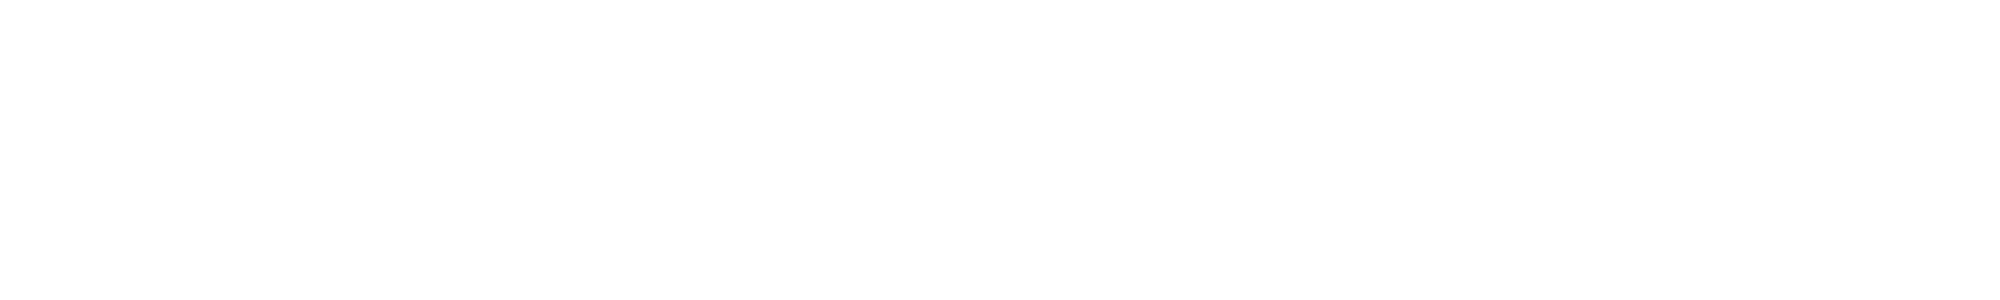

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [43]:
tick_locations = [value for value in x_axis]
plt.figure(figsize=(20,3))
plt.bar(x_axis, grouped_nyc_capture["Total_recycle_vs_Total_waste"], color='r', alpha=0.5, align="edge")
plt.xticks(tick_locations, nyc_capture_transformed["Total_capture_rate"], rotation="vertical")
#plt.show()



In [85]:
#write to mysql workbench database
connection_string = "root:password@localhost:3306/nyc_recycle_db"
engine = create_engine(f'mysql+pymysql://{connection_string}')
# Confirm tables
#Base.metadata.create_all(engine)
engine.table_names()

['nyc_waste_capture_rate']

In [108]:
# The ORM’s “handle” to the database is the Session.
from sqlalchemy.orm import Session
session = Session(engine)
# The ORM’s “handle” to the database is the Session.
from sqlalchemy.orm import Session
engine.execute('select * from nyc_waste_capture_rate').fetchall()

[(0, 'Brooklyn North', 'BKN01', 2008, 'April', 60.6880742089563, 424.301096979533),
 (1, 'Brooklyn North', 'BKN02', 2008, 'April', 67.9414058051355, 406.543897955661),
 (2, 'Brooklyn North', 'BKN03', 2008, 'April', 51.0983489665718, 298.577351413774),
 (3, 'Brooklyn North', 'BKN04', 2008, 'April', 55.3565636016721, 348.465213935367),
 (4, 'Brooklyn North', 'BKN05', 2008, 'April', 51.0420983125947, 293.722364243606),
 (5, 'Brooklyn North', 'BKN08', 2008, 'April', 61.2897627682849, 430.255471855415),
 (6, 'Brooklyn North', 'BKN09', 2008, 'April', 53.1040695926325, 309.703291109575),
 (7, 'Brooklyn North', 'BKN16', 2008, 'April', 45.5547599816586, 242.341104152752),
 (8, 'Brooklyn North', 'BKN17', 2008, 'April', 59.2985769899713, 383.206887434095),
 (9, 'Brooklyn South', 'BKS06', 2008, 'April', 77.3618083705989, 583.789883085096),
 (10, 'Brooklyn South', 'BKS07', 2008, 'April', 70.210166803323, 577.773702091813),
 (11, 'Brooklyn South', 'BKS10', 2008, 'April', 72.2449871649751, 617.480451

In [111]:
#Add data to sql table
#nyc_capture_transformed.to_sql(con=engine, name='nyc_waste_capture_rate', if_exists='append')
#grouped_nyc_capture.to_sql(con=engine, name='nyc_waste_capture_rate3', if_exists='append')

InternalError: (pymysql.err.InternalError) (1170, "BLOB/TEXT column 'Zone' used in key specification without a key length") [SQL: 'CREATE INDEX `ix_nyc_waste_capture_rate3_Zone` ON nyc_waste_capture_rate3 (`Zone`)'] (Background on this error at: http://sqlalche.me/e/2j85)